In [66]:
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from functools import reduce
from keras.optimizers import Adam

In [29]:
df = pd.read_excel("../data/extra/IGC50.xlsx")
df.head(100)
df.drop(df[df.smiles.isna()].index, inplace = True)
# df.drop(df[df.atc.isna()].index, inplace = True)
# df.drop(df[[False if len(smile)<250 else True for smile in df.smiles]].index, inplace = True)

In [30]:
len(reduce(lambda x,y: x if len(x)>len(y) else y, df.smiles))

52

In [31]:
df.head()

,smiles,Activity,split
0,OC(=O)C1=C(Cl)C=CC=C1Cl,2.33,1
1,OC(=O)C1=C(Cl)C=C(Cl)C=C1Cl,2.59,1
2,OC(=O)C1=CC=CC(=C1Cl)Cl,2.59,1
3,OC(=O)C1=CC(=CC=C1Cl)Cl,2.54,1
4,OC1=C(C=C(C=C1)[N+]([O-])=O)[N+]([O-])=O,4.06,1


In [32]:
df.describe()

,Activity,split
count,1792.000000,1792.000000
mean,3.265695,0.800223
std,1.051004,0.399944
min,0.334000,0.000000
25%,2.525250,1.000000
50%,3.250000,1.000000
75%,3.980000,1.000000
max,6.360000,1.000000


In [33]:
df['smiles'] = [smile.ljust(52, '*') for smile in df['smiles']] 

### One Hot Encoding

In [34]:
vocabulary = set()
allSmiles = ""
for smile in df['smiles']:
    allSmiles+=smile
    for char in smile:
        vocabulary.add(char)
freq = Counter(allSmiles).most_common(25)

In [35]:
vocabulary = [a for a,b in freq]

In [36]:
'*' in vocabulary

True

In [37]:
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(np.asarray(vocabulary).reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [38]:
def encodeSmile(smile, oe):
    word = []
    for char in smile:
        temp = list(oe.transform(np.asarray([char]).reshape(1, -1)).toarray()[0])
        word = word + temp
    return np.asarray(word, dtype=int)

In [39]:
X = []
X = [encodeSmile(smile, oe) for smile in df['smiles']]

In [40]:
X = np.asarray(X)

In [44]:
# ATCclasssubset = ['A', 'J', 'N', 'C']
# num_classes = len(ATCclasssubset)

# X_df = pd.DataFrame(X)
# X_df['target'] = df['atc1']
# X_df = X_df[X_df['target'].isin(ATCclasssubset)]
# g = X_df.groupby('target')
# X_df = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

# X = X_df[X_df.columns[:-1]]

X.shape

(1792, 1300)

### Prepare Data

In [46]:
y = df.Activity

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Helper function

In [90]:
def accuracy(y_true, y_pred):
    plt.figure(figsize=(10, 10))
    plt.plot(range(0, y_true.shape[0]), y_true)
    plt.plot(range(0, y_true.shape[0]), y_pred)    

In [58]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [59]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Make the network

In [92]:
class Network:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Reshape((52, 25), input_shape=(1300, )))
        self.model.add(Conv1D(192, 5, activation='relu', input_shape=(250, 25)))
        self.model.add(MaxPool1D(5))
        self.model.add(BatchNormalization())        
#         self.model.add(Conv1D(192, 5, activation='relu'))
        self.model.add(Conv1D(140, 3, activation='relu'))
#         self.model.add(LSTM(70, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(70, dropout=0.4, recurrent_dropout=0.2, activation='relu'))
        self.model.add(Flatten())
#         self.model.add(Dense(100, activation='relu'))
        self.model.add(Dropout(rate=0.4))
        self.model.add(Dense(1, activation='linear'))
        
        optimizer = Adam(lr=0.00025)
        lr_metric = get_lr_metric(optimizer)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=[coeff_determination])
        print(self.model.summary())
        
    def train(self, X, y, X_test, y_test, epochs=20):
        self.model.fit(X, y, epochs=epochs, validation_data=(X_test, y_test))
    
    def test(self, X, y_true):
        y_pred = self.model.predict(X)
        accuracy(y_true, y_pred)
        

In [93]:
network = Network(1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 52, 25)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 48, 192)           24192     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 192)            0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 9, 192)            768       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 7, 140)            80780     
_________________________________________________________________
flatten_10 (Flatten)         (None, 980)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 980)               0         
__________

In [94]:
network.train(X_train, y_train, X_test, y_test, epochs=10)

Train on 1200 samples, validate on 592 samples
Epoch 1/10
1200/1200 [==============================] - 2s 2ms/step - loss: 2.4985 - coeff_determination: -1.4205 - val_loss: 0.7987 - val_coeff_determination: 0.2461
Epoch 2/10
1200/1200 [==============================] - 1s 491us/step - loss: 1.1944 - coeff_determination: -0.1893 - val_loss: 0.6427 - val_coeff_determination: 0.4014
Epoch 3/10
1200/1200 [==============================] - 1s 501us/step - loss: 0.9320 - coeff_determination: 0.0772 - val_loss: 0.6249 - val_coeff_determination: 0.4160
Epoch 4/10
1200/1200 [==============================] - 1s 503us/step - loss: 0.7714 - coeff_determination: 0.2619 - val_loss: 0.5258 - val_coeff_determination: 0.5058
Epoch 5/10
1200/1200 [==============================] - 1s 510us/step - loss: 0.7191 - coeff_determination: 0.2979 - val_loss: 0.5019 - val_coeff_determination: 0.5258
Epoch 6/10
1200/1200 [==============================] - 1s 494us/step - loss: 0.6197 - coeff_determination: 0.400

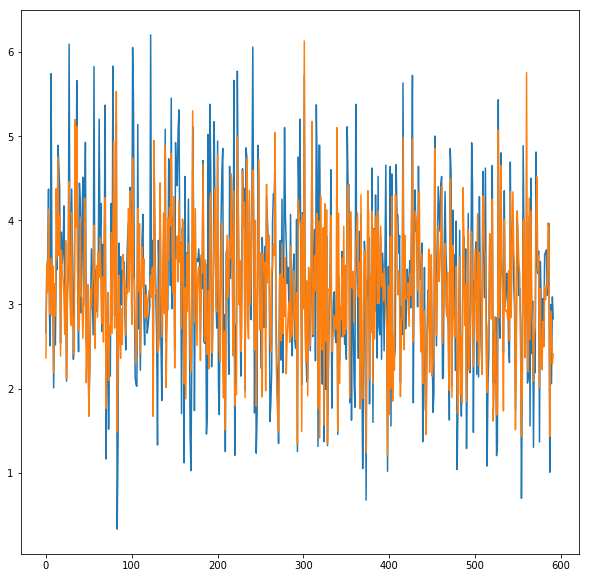

In [95]:
s = network.test(X_test, y_test)